In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import yaml
from collections import deque

from AntController.AntEnvironment import AntIRLEnvironment
from AntController.HaikuActorCritic import HaikuContinuousActorCritic, EpisodeWithValue
from AntController.HaikuPredictor import HaikuPredictor
from AntController.AntActorCritic import AntActorCritic

<IPython.core.display.Javascript object>


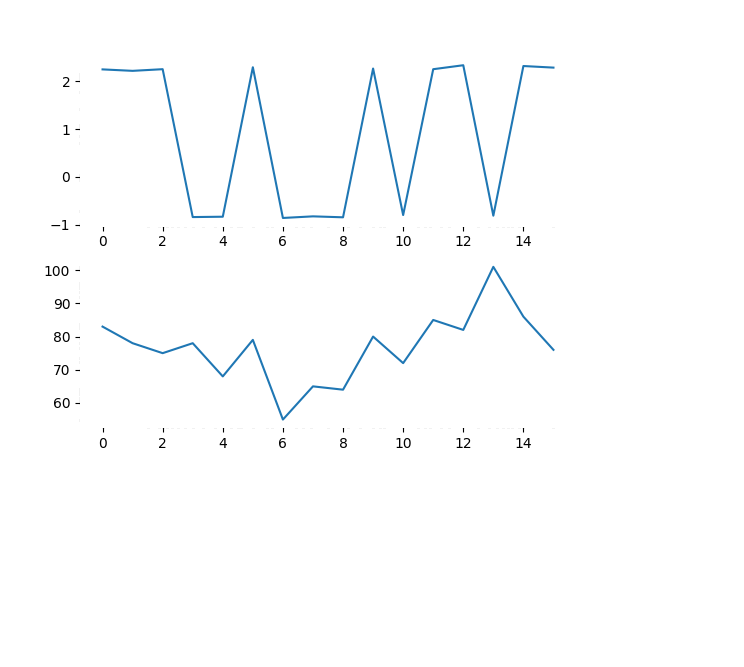

Connecting to Antony via serial...
Waiting for Antony to respond...
Ready!


/home/charlie/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Robot is frozen -- resetting the connection...


In [ ]:
%matplotlib notebook

path = "AntController/configs/ant_aac_config_no_sensor.yaml"
with open(path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

plt.ion()
fig = plt.figure()
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

reward_plot, = ax.plot([], [])
frames_plot, = ax2.plot([], [])

rewards_data = []
frames_data = []
critic_losses = []

env = AntIRLEnvironment(sensors_enabled=False)
aac = AntActorCritic(config, env)
aac.actor.name = "actor_no_sensor"
aac.value_critic.name = "critic_no_sensor"
try:
    for episode in range(10000):
        try:
            episode_data, critic_loss = aac.run_episode_and_train(True)

            total_rewards = np.sum(episode_data.rewards)
            frames = len(episode_data.states)
            rewards_data.append(total_rewards)
            frames_data.append(frames)
            critic_losses.append(critic_loss)

            if episode % 5 == 0:
                aac.save_weights()

            reward_plot.set_ydata(np.append(reward_plot.get_ydata(), total_rewards))
            reward_plot.set_xdata(np.append(reward_plot.get_xdata(), episode))
            frames_plot.set_ydata(np.append(frames_plot.get_ydata(), frames))
            frames_plot.set_xdata(np.append(frames_plot.get_xdata(), episode))

            ax.relim()
            ax.autoscale_view()
            ax2.relim()
            ax2.autoscale_view()
            fig.canvas.draw()
            fig.canvas.flush_events()
        except ValueError:
            print(
                "Actor has reached a bad state, likely due to exploding gradients.")
            aac.reset_to_previous_version(5)
finally:
    pickle.dump((rewards_data, frames_data, critic_losses), open("configs/latest_data.p", "wb"))
